#Importación de librerías y creación de funciones necesarias

In [115]:
import os
import numpy as np
import string
#Librerías de preprocesamiento y visualización de imágenes:
import skimage.data 
from skimage.io import imshow,imsave
from skimage.util import crop
from skimage import img_as_ubyte,img_as_float
from skimage.transform import resize
import matplotlib.pyplot as plt
import scipy.ndimage
import cv2
from PIL import Image
#Librerías de machine learning y deep learning
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping

Conexión con Google Drive para almacenar y acceder a los *croppies*:

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


FUNCIONES NECESARIAS:

In [35]:
#Devuelve las coordenadas de las esquinas izquierda superior y la derecha inferior del cuadro blanco que contiene al asteroide
def coordenadas_cuadro(imagen):
  imagen_gris=cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)
  ret, thresh = cv2.threshold(imagen_gris, 254, 255, cv2.THRESH_BINARY)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  y1,x1=contours[0][0][0]
  y2,x2=contours[0][2][0]
  return x1,y1,x2,y2

In [150]:
#Recorta el interior del recuadro blanco
def recorte(imagen):
   x1,y1,x2,y2=coordenadas_cuadro(imagen)
   cropp=imagen[x1+1:x2,y1+1:y2]
   return cropp

In [156]:
#Estandariza el tamaño de imagen
def estandar(imagen):
    imagen=cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)
    ret,imagen=cv2.threshold(imagen, 0, 255, cv2.THRESH_BINARY)
    x, y = imagen.shape
    imagen=Image.fromarray(imagen)
    nueva_imagen = Image.new('1', (50,40))
    nueva_imagen.paste(imagen,(int(25.-x/2.),int(20.-y/2.)))
    return nueva_imagen

**CÓDIGO DE PREPROCESAMIENTO DE LOS *CROPPIES* PREVIO AL CLASIFICADOR:**

In [170]:
#Aplica el preprocesamiento previo a la clasificación del algoritmo. Recorta el interior del cuadro blanco y devuelve una imagen de tamaño estandar.
#Las fuentes se corresponden con pixeles blancos sobre fondo negro.
def preprocesado(imagen):
  cropp=recorte(imagen)
  cropp_final=estandar(cropp)
  return cropp_final

In [66]:
#Devuelve el color mayoritario de un croppie (o recorte del croppie) con su número de píxeles, así como los demás colores con su frecuencia. Se excluye el negro y el blanco (se tienen en cuenta solo las fuentes)
def colores(imagen):
  colores_frecuencia={}
  colores_indice={}
  f=0
  i=0
  for fila in imagen:
    colores=np.unique(fila,axis=0,return_counts=True)[0].tolist()
    frecuencias=np.unique(fila,axis=0,return_counts=True)[1].tolist()
    for color,frecuencia in zip(colores,frecuencias):
     
      if (color!=[0,0,0]) and (color!=[255,255,255]) and (color in colores_indice.values()):
          for index, col in colores_indice.items():
            if col==color:
              colores_frecuencia[index]=colores_frecuencia[index]+frecuencia
              break
      elif (color!=[0,0,0]) and (color!=[255,255,255]) and (color not in colores_indice.values()):
          colores_indice[i]=color
          colores_frecuencia[i]=frecuencia
          i+=1
     
      f+=1
  indice_maximo = max(colores_frecuencia, key=colores_frecuencia.get)
  color_mayoritario=colores_indice[indice_maximo]
  frecuencia_maxima=colores_frecuencia[indice_maximo]
  colores=[colores_indice[i] for i in colores_indice.keys()]
  frecuencias=[colores_frecuencia[i] for i in colores_indice.keys()]
  return color_mayoritario, frecuencia_maxima, colores,frecuencias

In [67]:
#Cuenta el número de píxeles negros de un croppie (o recorte de croppie)
def negro(imagen):
  frec=0
  for fila in imagen:
    colores=np.unique(fila,axis=0,return_counts=True)[0].tolist()
    frecuencias=np.unique(fila,axis=0,return_counts=True)[1].tolist()
    for color,frecuencia in zip(colores,frecuencias):
      if color==[0,0,0]:
        frec+=frecuencia
          
  return frec

In [ ]:
#Detecta croppies con líneas horizontales que ocupan un cierto porcentaje de la imagen.
def lineas_horizontales(imagen,porcentaje):
  num_columnas=len(imagen[0])
  for fila in imagen:
         colores=np.unique(fila,axis=0,return_counts=True)[0].tolist()
         frecuencias=np.unique(fila,axis=0,return_counts=True)[1].tolist()
         if [0,0,0] in colores:
            indice_negro=colores.index([0,0,0])
            colores.remove([0,0,0])
            frecuencias.remove(frecuencias[indice_negro])
         if [255,255,255] in colores:
            indice_blanco=colores.index([255,255,255])
            colores.remove([255,255,255])
            frecuencias.remove(frecuencias[indice_blanco])
         if (frecuencias!=[]) and (sum(frecuencias)>porcentaje*num_columnas):
           return True
           break
           
  return False        

In [ ]:
#Detecta croppies con líneas verticales que ocupan un cierto porcentaje de la imagen.
def lineas_verticales(imagen,porcentaje):
  num_filas=len(imagen)
  num_columnas=len(imagen[0])
  for i in range(num_columnas):
    columna=[]
    for fila in imagen:
         columna.append(fila[i])
    colores=np.unique(columna,axis=0,return_counts=True)[0].tolist()
    frecuencias=np.unique(columna,axis=0,return_counts=True)[1].tolist()
    if [0,0,0] in colores:
          indice_negro=colores.index([0,0,0])
          colores.remove([0,0,0])
          frecuencias.remove(frecuencias[indice_negro])
    if [255,255,255] in colores:
          indice_blanco=colores.index([255,255,255])
          colores.remove([255,255,255])
          frecuencias.remove(frecuencias[indice_blanco])
    if (frecuencias!=[]) and (sum(frecuencias)>porcentaje*num_filas):
           return True
           break
           
  return False   

In [180]:
#Detecta croppies con cierta ocupación de fuentes en los bordes de la región limitada por el cuadro blanco
def bordes(imagen,porcentaje): 
  x1,y1,x2,y2=coordenadas_cuadro(imagen)
  borde_superior=imagen[x1+1:x1+2,y1+1:y2]
  borde_inferior=imagen[x2-1:x2,y1+1:y2]
  borde_izquierdo=imagen[x1+1:x2,y1+1:y1+2]
  borde_derecho=imagen[x1+1:x2,y2-1:y2]
  if lineas_verticales(borde_izquierdo,porcentaje) or lineas_verticales(borde_derecho,porcentaje) or lineas_horizontales(borde_superior,porcentaje) or lineas_horizontales(borde_inferior,porcentaje):
    return True
  else:
    return False

In [179]:
#Detecta croppies con fuentes en el centro del cuadro blanco
def centro_con_fuente(imagen):
   x1,y1,x2,y2=coordenadas_cuadro(imagen)
   centro_x=x1+((x2-x1)//2)
   centro_y=y1+((y2-y1)//2)
   centro=imagen[centro_x-2:centro_x+3,centro_y-2:centro_y+3]
   for fila in centro:
     for pixel in fila:
       if pixel[0]!=0 or pixel[1]!=0 or pixel[2]!=0:
         return True
         break
   return False


In [48]:
#Detecta filas con al menos n píxeles consecutivos
def pixeles_continuos_horizontales(imagen,n):
  num_columnas=len(imagen[0])
  for fila in imagen:
    color_anterior=fila[0]
    cuenta=1
    for i in range(1,num_columnas):
         color=fila[i]
         if ((color[0]!=0) or (color[1]!=0) or (color[2]!=0)) and (color[0]==color_anterior[0]) and (color[1]==color_anterior[1]) and (color[2]==color_anterior[2]):
             cuenta+=1

         else:
           color_anterior=color
    if cuenta>=n:
        return True
        break
  return False

In [49]:
#Detecta columnas con al menos n píxeles consecutivos
def pixeles_continuos_verticales(imagen,n):
  num_columnas=len(imagen[0])
  num_filas=len(imagen)
  for i in range(num_columnas):
    columna=[]
    cuenta=1
    for fila in imagen:
         columna.append(fila[i])
    color_anterior=columna[0]
    for i in range(1,num_filas):
        color=columna[i]
        if ((color[0]!=0) or (color[1]!=0) or (color[2]!=0)) and (color[0]==color_anterior[0]) and (color[1]==color_anterior[1]) and (color[2]==color_anterior[2]):
             cuenta+=1

        else:
           color_anterior=color
    if cuenta>=n:
        return True
        break
  return False

**CÓDIGO QUE PERMITE DESCARTAR FUENTES CONTAMINADAS:**

In [178]:
#Detecta las fuentes no contaminadas 
def no_contaminada(imagen,N):
  cuadro=recorte(imagen)
  color_mayoritario1, frecuencia_maxima1, colores1,frecuencias1=colores(cuadro)
  num_pixeles_cuadro=np.sum(frecuencias1)
  x1,y1,x2,y2=coordenadas_cuadro(imagen)
  cropp=imagen[x1-N:x2+N+1,y1-N:y2+N+1]
  color_mayoritario2, frecuencia_maxima2, colores2,frecuencias2=colores(cropp)
  num_pixeles_cropp=np.sum(frecuencias2)
  num_pixeles_entorno=num_pixeles_cropp-num_pixeles_cuadro
  if num_pixeles_entorno==0 and len(colores1)==1:
    return True
  else:
    return False

# Datos de entrenamiento. Varuna (sección 3.2 de la memoria)

Se cambian los engorrosos nombres de los *croppies* de Varuna por su fecha. De esta manera se pueden ordenar temporalmente y encontrar secuencias de imágenes, que ayudan a identificar las fuentes mezcladas.

Inicialmente las detecciones positivas de $m2$ se encuentran en el directorio **asteroid found** y las negativas en **asteroid_not_found**

Se guardan las detecciones positivas con el nombre modificado en el directorio **Positivas** y las negativas en **Negativas**

In [ ]:
nombres_nuevos=[]
if os.path.isdir("./drive/MyDrive/TFM/asteroid_found/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/asteroid_found/"):
             if nombre.endswith(".png"):
                imagen = cv2.imread("./drive/MyDrive/TFM/asteroid_found/%s"%nombre)
                imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
                lista=[index for index, letra in enumerate(nombre) if letra=='T']
                if len(lista)==0:
                            imsave("./drive/MyDrive/TFM/FINAL/Positivas/%s"%nombre,imagen)
                elif len(lista)==1:
                            index=lista[0]
                            año=nombre[index-10:index-6]
                            mes=nombre[index-5:index-3]
                            dia=nombre[index-2:index]
                            hora=nombre[index+1:index+3]
                            minuto=nombre[index+4:index+6]
                            segundo=nombre[index+7:index+9]
                            nombre_final=año+"-"+mes+"-"+dia+"_"+hora+":"+minuto+":"+segundo+".png"
                            if nombre_final in nombres_nuevos:
                                           imsave("./drive/MyDrive/TFM/FINAL/Positivas/%s"%nombre,imagen)
                            else:
                                           imsave("./drive/MyDrive/TFM/FINAL/Positivas/%s"%nombre_final,imagen)
                                           nombres_nuevos.append(nombre_final)

                elif len(lista)==2:
                           index=lista[1]
                           año=nombre[index-10:index-6]
                           mes=nombre[index-5:index-3]
                           dia=nombre[index-2:index]
                           hora=nombre[index+1:index+3]
                           minuto=nombre[index+4:index+6]
                           segundo=nombre[index+7:index+9]
                           nombre_final=año+"-"+mes+"-"+dia+"_"+hora+":"+minuto+":"+segundo+".png"
                           if nombre_final in nombres_nuevos:
                                            imsave("./drive/MyDrive/TFM/FINAL/Positivas/%s"%nombre,imagen)
                           else:
                                            imsave("./drive/MyDrive/TFM/FINAL/Positivas/%s"%nombre_final,imagen)
                                            nombres_nuevos.append(nombre_final)

                elif len(lista)>2:
                          index=lista[2]
                          año=nombre[index-10:index-6]
                          mes=nombre[index-5:index-3]
                          dia=nombre[index-2:index]
                          hora=nombre[index+1:index+3]
                          minuto=nombre[index+4:index+6]
                          segundo=nombre[index+7:index+9]
                          nombre_final=año+"-"+mes+"-"+dia+"_"+hora+":"+minuto+":"+segundo+".png"
                          if nombre_final in nombres_nuevos:
                                            imsave("./drive/MyDrive/TFM/FINAL/Positivas/%s"%nombre,imagen)
                          else:
                                            imsave("./drive/MyDrive/TFM/FINAL/Positivas/%s"%nombre_final,imagen)
                                            nombres_nuevos.append(nombre_final)

In [ ]:
nombres_nuevos=[]
if os.path.isdir("./drive/MyDrive/TFM/asteroid_not_found/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/asteroid_not_found/"):
             if nombre.endswith(".png"):
                imagen = cv2.imread("./drive/MyDrive/TFM/asteroid_not_found/%s"%nombre)
                imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
                lista=[index for index, letra in enumerate(nombre) if letra=='T']
                if len(lista)==0:
                            imsave("./drive/MyDrive/TFM/FINAL/Negativas/%s"%nombre,imagen)
                elif len(lista)==1:
                            index=lista[0]
                            año=nombre[index-10:index-6]
                            mes=nombre[index-5:index-3]
                            dia=nombre[index-2:index]
                            hora=nombre[index+1:index+3]
                            minuto=nombre[index+4:index+6]
                            segundo=nombre[index+7:index+9]
                            nombre_final=año+"-"+mes+"-"+dia+"_"+hora+":"+minuto+":"+segundo+".png"
                            if nombre_final in nombres_nuevos:
                                           imsave("./drive/MyDrive/TFM/FINAL/Negativas/%s"%nombre,imagen)
                            else:
                                           imsave("./drive/MyDrive/TFM/FINAL/Negativas/%s"%nombre_final,imagen)
                                           nombres_nuevos.append(nombre_final)

                elif len(lista)==2:
                           index=lista[1]
                           año=nombre[index-10:index-6]
                           mes=nombre[index-5:index-3]
                           dia=nombre[index-2:index]
                           hora=nombre[index+1:index+3]
                           minuto=nombre[index+4:index+6]
                           segundo=nombre[index+7:index+9]
                           nombre_final=año+"-"+mes+"-"+dia+"_"+hora+":"+minuto+":"+segundo+".png"
                           if nombre_final in nombres_nuevos:
                                            imsave("./drive/MyDrive/TFM/FINAL/Negativas/%s"%nombre,imagen)
                           else:
                                            imsave("./drive/MyDrive/TFM/FINAL/Negativas/%s"%nombre_final,imagen)
                                            nombres_nuevos.append(nombre_final)

                elif len(lista)>2:
                          index=lista[2]
                          año=nombre[index-10:index-6]
                          mes=nombre[index-5:index-3]
                          dia=nombre[index-2:index]
                          hora=nombre[index+1:index+3]
                          minuto=nombre[index+4:index+6]
                          segundo=nombre[index+7:index+9]
                          nombre_final=año+"-"+mes+"-"+dia+"_"+hora+":"+minuto+":"+segundo+".png"
                          if nombre_final in nombres_nuevos:
                                            imsave("./drive/MyDrive/TFM/FINAL/Negativas/%s"%nombre,imagen)
                          else:
                                            imsave("./drive/MyDrive/TFM/FINAL/Negativas/%s"%nombre_final,imagen)
                                            nombres_nuevos.append(nombre_final)
                

  

## Código de descarte

Se descartan los *croppies* sin asteroide, los que tienen un asteroide demasiado pequeño o poco compacto (píxeles muy dispersos), los de baja y muy baja calidad y los contaminados, es decir aquellos que poseen píxeles ocupados en un radio de 4 píxeles alrededor del cuadro blanco. De esta manera se filtran solo los *croppies* de buena calidad.

In [ ]:
if os.path.isdir("./drive/MyDrive/TFM/FINAL/Positivas/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/FINAL/Positivas/"):
                imagen_original= cv2.imread("./drive/MyDrive/TFM/FINAL/Positivas/%s"%nombre)
                imagen_color=cv2.cvtColor(imagen_original, cv2.COLOR_BGR2RGB)
                imagen_gris = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)
                #1. Descarta croppies sin asteroide
                imagen=preprocesado(imagen_original)
                imagen=img_as_ubyte(imagen)
                num_pixeles_asteroide=np.sum(imagen == 255)
                if num_pixeles_asteroide==0:
                    imsave("./drive/MyDrive/TFM/FINAL/DESCARTADAS_POSITIVAS/%s"%nombre,imagen_color)
                 
                else:
                    #2. Descarta croppies con un porcentaje demasiado alto de ocupación de píxeles, lo que indica una mala calidad
                    ret,imagen2=cv2.threshold(imagen_gris, 0, 255, cv2.THRESH_BINARY)
                    imagen2=img_as_ubyte(imagen2)
                    num_pixeles_fuentes=np.sum(imagen2 == 255)
                    num_pixeles_sin_fuentes=np.sum(imagen2== 0)
                    porcent= num_pixeles_fuentes/(num_pixeles_sin_fuentes+num_pixeles_fuentes)
                    cuadro=recorte(imagen_color)
                    color_mayoritario_cuadro, frecuencia_maxima_cuadro, colores_cuadro,frecuencias_cuadro=colores(cuadro)
                    if porcent>=0.3:
                        imsave("./drive/MyDrive/TFM/FINAL/DESCARTADAS_POSITIVAS/%s"%nombre,imagen_color)
                    #3. Descarta croppies contaminados
                    elif no_contaminada(imagen_color,4)==False:
                        imsave("./drive/MyDrive/TFM/FINAL/DESCARTADAS_POSITIVAS/%s"%nombre,imagen_color)
                    #4. Descarta croppies con varias fuentes no mezcladas, con asteroides demasiado pequeños o poco compactos (forma muy dispersa)
                    elif pixeles_continuos_horizontales(cuadro,3)==False or pixeles_continuos_verticales(cuadro,3)==False or (frecuencia_maxima_cuadro<=7) or len(colores_cuadro)>1:
                        imsave("./drive/MyDrive/TFM/FINAL/DESCARTADAS_POSITIVAS/%s"%nombre,imagen_color)
                    else:
                          imsave("./drive/MyDrive/TFM/FINAL/FILTRADAS_POSITIVAS/%s"%nombre,imagen_color)

In [ ]:
if os.path.isdir("./drive/MyDrive/TFM/FINAL/Negativas/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/FINAL/Negativas/"):
                imagen_original= cv2.imread("./drive/MyDrive/TFM/FINAL/Negativas/%s"%nombre)
                imagen_color=cv2.cvtColor(imagen_original, cv2.COLOR_BGR2RGB)
                imagen_gris = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)
                #1. Descarta croppies sin asteroide
                imagen=preprocesado(imagen_original)
                imagen=img_as_ubyte(imagen)
                num_pixeles_asteroide=np.sum(imagen == 255)
                if num_pixeles_asteroide==0:
                    imsave("./drive/MyDrive/TFM/FINAL/DESCARTADAS_NEGATIVAS/%s"%nombre,imagen_color)
                 
                else:
                    #2. Descarta croppies con un porcentaje demasiado alto de ocupación de píxeles, lo que indica una mala calidad
                    ret,imagen2=cv2.threshold(imagen_gris, 0, 255, cv2.THRESH_BINARY)
                    imagen2=img_as_ubyte(imagen2)
                    num_pixeles_fuentes=np.sum(imagen2 == 255)
                    num_pixeles_sin_fuentes=np.sum(imagen2== 0)
                    porcent= num_pixeles_fuentes/(num_pixeles_sin_fuentes+num_pixeles_fuentes)
                    cuadro=recorte(imagen_color)
                    color_mayoritario_cuadro, frecuencia_maxima_cuadro, colores_cuadro,frecuencias_cuadro=colores(cuadro)
                    if porcent>=0.3:
                        imsave("./drive/MyDrive/TFM/FINAL/DESCARTADAS_NEGATIVAS/%s"%nombre,imagen_color)
                    #3. Descarta croppies contaminados
                    elif no_contaminada(imagen_color,4)==False:
                        imsave("./drive/MyDrive/TFM/FINAL/DESCARTADAS_NEGATIVAS/%s"%nombre,imagen_color)
                    #4. Descarta croppies con varias fuentes no mezcladas, con asteroides demasiado pequeños o poco compactos (forma muy dispersa)
                    elif pixeles_continuos_horizontales(cuadro,3)==False or pixeles_continuos_verticales(cuadro,3)==False or (frecuencia_maxima_cuadro<=7) or len(colores_cuadro)>1:
                        imsave("./drive/MyDrive/TFM/FINAL/DESCARTADAS_NEGATIVAS/%s"%nombre,imagen_color)
                    else:
                          imsave("./drive/MyDrive/TFM/FINAL/FILTRADAS_NEGATIVAS/%s"%nombre,imagen_color)

Una vez obtenidos los *croppies* de buena calidad se clasifican manualmente en dos grupos: **fuentes aisladas**, es decir, aquellos *croppies* en los que dentro del cuadro blanco se encuentra solo el asteroide y **fuentes mezcladas**, en las que hay una mezcla del asteroide con una estrella de fondo. 

Las fuentes aisladas son todas **no contaminadas** y las fuentes mezcladas seleccionadas pertenecen a los *croppies* de mayor calidad.
Las fuentes aisladas se guardan en el directorio **Mezclado_NO** y las mezcladas en **Mezclado_SI**. Se muestran algunas de las imágenes:

In [ ]:
imagenes=[]
y=[]
for i in range(0,10):
  nombre=os.listdir("./drive/MyDrive/TFM/FINAL/Mezclado_SI/")[i]
  imagen=cv2.imread("./drive/MyDrive/TFM/FINAL/Mezclado_SI/%s"%nombre)
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
  imagenes.append(imagen)
  y.append('Mezcla_fuentes')

for i in range(0,10):
  nombre=os.listdir("./drive/MyDrive/TFM/FINAL/Mezclado_NO/")[i]
  imagen=cv2.imread("./drive/MyDrive/TFM/FINAL/Mezclado_NO/%s"%nombre)
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
  imagenes.append(imagen)
  y.append('Fuente_aislada')

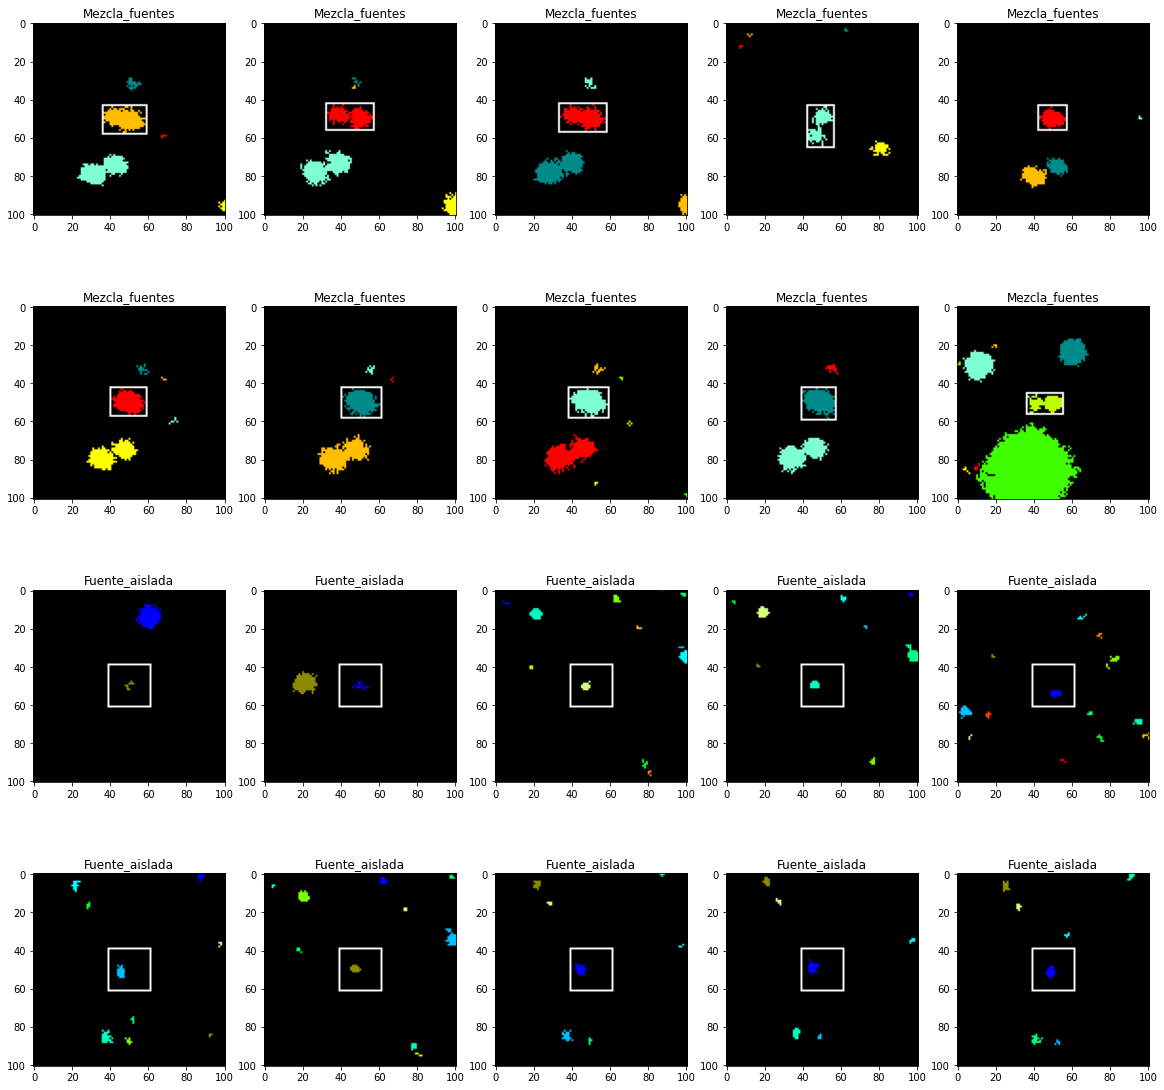

In [ ]:
fig,axs=plt.subplots(4,5,figsize=(20, 20))

for ax,imagen,etiqueta in zip(axs.flatten(),imagenes,y):
  ax.imshow(imagen)
  ax.set_title(etiqueta)

# Preprocesamiento (sección 3.3 de la memoria)

Se leen los *croppies* de cada directorio y se preprocesan para poder ser clasificados. Se guardan los croppies preprocesados en **Mezclado_SI_preprocesado** y **Mezclado_NO_preprocesado**. 

In [ ]:
if os.path.isdir("./drive/MyDrive/TFM/FINAL/Mezclado_SI/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/FINAL/Mezclado_SI/"):
             if nombre.endswith(".png"):
              imagen = cv2.imread("./drive/MyDrive/TFM/FINAL/Mezclado_SI/%s"%nombre)
              imagen=preprocesado(imagen)
              imagen = img_as_float(imagen)
              imsave("./drive/MyDrive/TFM/FINAL/Mezclado_SI_preprocesado/%s"%nombre,imagen)
              

if os.path.isdir("./drive/MyDrive/TFM/FINAL/Mezclado_NO/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/FINAL/Mezclado_NO/"):
             if nombre.endswith(".png"):
                imagen = cv2.imread("./drive/MyDrive/TFM/FINAL/Mezclado_NO/%s"%nombre)
                imagen=preprocesado(imagen)
                imagen = img_as_float(imagen)
                imsave("./drive/MyDrive/TFM/FINAL/Mezclado_NO_preprocesado/%s"%nombre,imagen)

Se muestran algunos ejemplos:

In [ ]:
imagenes_prep=[]
y=[]
for i in range(0,10):
  nombre=os.listdir("./drive/MyDrive/TFM/FINAL/Mezclado_SI_preprocesado/")[i]
  imagen=cv2.imread("./drive/MyDrive/TFM/FINAL/Mezclado_SI_preprocesado/%s"%nombre)
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
  imagenes_prep.append(imagen)
  y.append('Mezcla_fuentes')

for i in range(0,10):
  nombre=os.listdir("./drive/MyDrive/TFM/FINAL/Mezclado_NO_preprocesado/")[i]
  imagen=cv2.imread("./drive/MyDrive/TFM/FINAL/Mezclado_NO_preprocesado/%s"%nombre)
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
  imagenes_prep.append(imagen)
  y.append('Fuente_aislada')

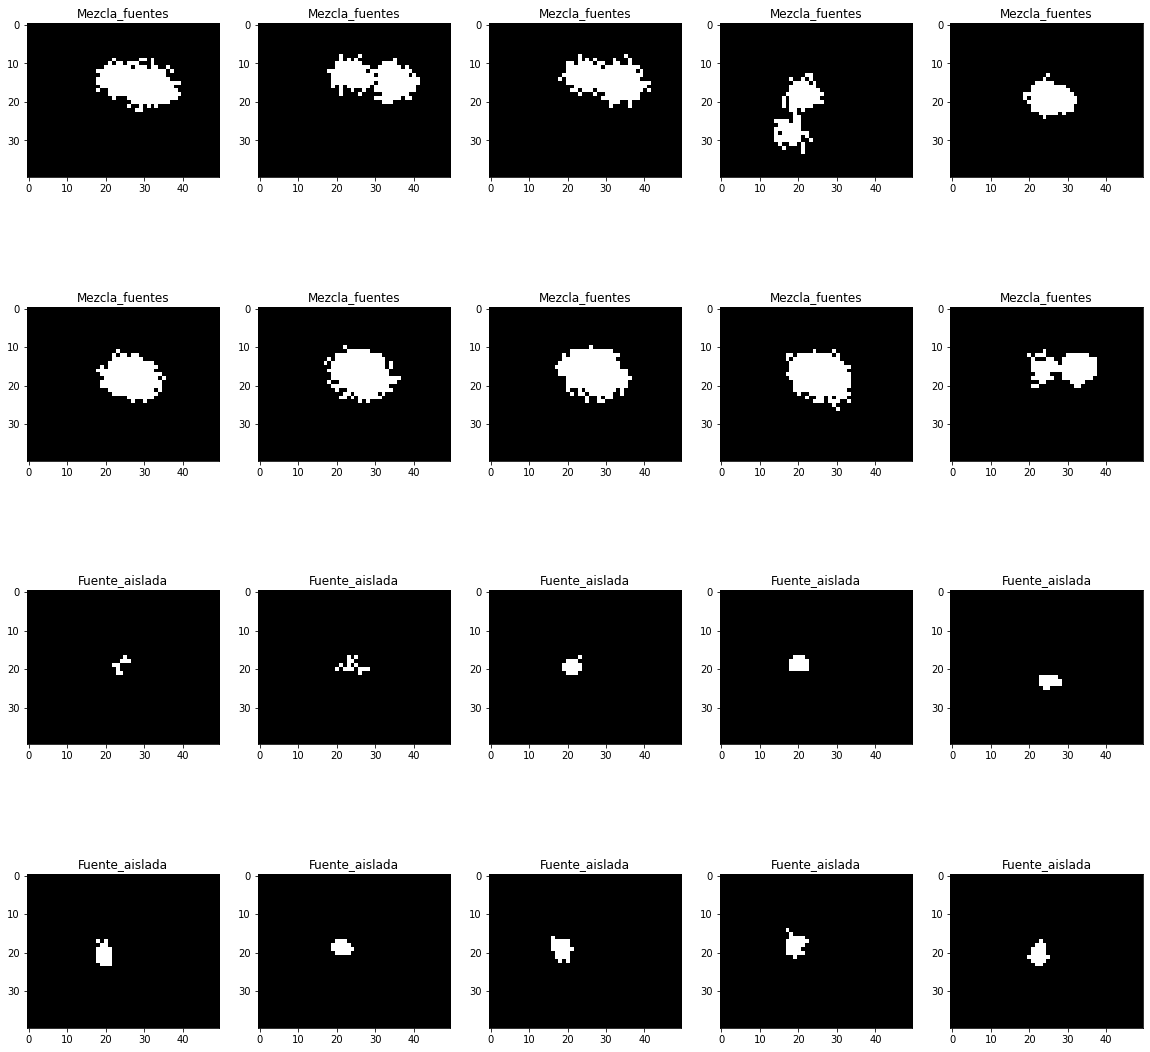

In [ ]:
fig,axs=plt.subplots(4,5,figsize=(20, 20))

for ax,imagen,etiqueta in zip(axs.flatten(),imagenes_prep,y):
  ax.imshow(imagen)
  ax.set_title(etiqueta)

Como hay muchos menos *croppies* que presentan mezcla respecto a las fuentes aisladas, es necesario aplicar *data augmentation* para equilibrar las dos clases (si no el algoritmo memorizará la clase mayoritaria); es decir se modifican los *croppies* con mezcla preprocesados a través de translaciones para que actúen como si fueran *croppies* diferentes.

In [ ]:
print(len(os.listdir("./drive/MyDrive/TFM/FINAL/Mezclado_SI_preprocesado/")))

80


In [ ]:
print(len(os.listdir("./drive/MyDrive/TFM/FINAL/Mezclado_NO_preprocesado/")))

2005


In [ ]:
def data_augmentation(N):
  #Se generan N croppies a partir de cada uno de los originales
  directorio='./drive/MyDrive/TFM/FINAL/Mezclado_SI_preprocesado/'
  imagenes=np.zeros((len(os.listdir(directorio)),40,50))
  i=0
  nombres=[]
  for nombre in os.listdir(directorio):
      imagen = cv2.imread(directorio+nombre)
      imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
      nombres.append(nombre)
      imagenes[i]=imagen
      i+=1
  

  generador=image.ImageDataGenerator(
    width_shift_range=3, 
    height_shift_range=2) 
   
  for i in range(len(imagenes)):
    n=0
    imagen=imagenes[i]
    nombre=nombres[i]
    for batch in generador.flow(imagen.reshape(1,40,50,1),batch_size=1):
      imagen_generada=batch[0]
      imsave('./drive/MyDrive/TFM/FINAL/Mezclado_SI_preprocesado_aumentado/%s'%(str(n)+'_'+nombre),imagen_generada)
      n+=1
      i+=1
      if n==N:
        break

Para equilibrar las clases se obtienen 25 *croppies* aumentados de cada *croppie* original.

In [ ]:
data_augmentation(25)

In [ ]:
print(len(os.listdir("./drive/MyDrive/TFM/FINAL/Mezclado_SI_preprocesado_aumentado/")))

2000


Se guardan las imágenes de entrenamiento en un array (**x**), sus nombres (**nombres**) y sus etiquetas (**y**).

In [ ]:
x=np.zeros((4005,40,50))
nombres=[]
y=[]
n=0
if os.path.isdir("./drive/MyDrive/TFM/FINAL/Mezclado_SI_preprocesado_aumentado/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/FINAL/Mezclado_SI_preprocesado_aumentado/"):
             if nombre.endswith(".png"):
                nombres.append(nombre)
                y.append('Si')
                imagen = cv2.imread("./drive/MyDrive/TFM/FINAL/Mezclado_SI_preprocesado_aumentado/%s"%nombre)
                imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
                x[n]=imagen
                n+=1
if os.path.isdir("./drive/MyDrive/TFM/FINAL/Mezclado_NO_preprocesado/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/FINAL/Mezclado_NO_preprocesado/"):
             if nombre.endswith(".png"):
                nombres.append(nombre)
                y.append('No')
                imagen = cv2.imread("./drive/MyDrive/TFM/FINAL/Mezclado_NO_preprocesado/%s"%nombre)
                imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
                x[n]=imagen
                n+=1

Se aumenta en una dimensión el array de las imágenes, para indicar el número de canales (en este caso 1, pues las imágenes preprocesadas son en blanco y negro). Este paso es necesario para poder introducirlas en la CNN.

In [ ]:
x=np.expand_dims(x,3)

Se pasan las etiquetas a entero para poder transformar a binario:

In [ ]:
clases_enteras = {'No':0,'Si':1}
y_entero=[]
for i in range(len(y)):
  entero=clases_enteras.get(y[i])
  y_entero.append(entero)

In [ ]:
y_binario = to_categorical(y_entero, 2)

A continuación se permutan aleatoriamente las imágenes (*suffle*) junto con los nombres y etiquetas correspondientes. Esto no es estrictamente necesario, pues durante el entrenamiento se realiza un *shuffle* si así se indica, pero para asegurar que a la red le llegan las clases intercaladas.

In [ ]:
permutacion = np.random.permutation(4005)
x= x[permutacion]
y_binario= y_binario[permutacion]
nombres=np.array(nombres)
nombres=nombres[permutacion]

Se separan los datos en **entrenamiento** (80%) y **test** (20%). 

In [ ]:
x_train, x_test, y_train, y_test, nombres_train, nombres_test = train_test_split(x, y_binario, nombres, test_size=0.20, random_state=13)

# Compilado y entrenamiento (sección 3.5 de la memoria)


Se crea la arquitectura de red y se compila. Es una red con una sola etapa convolucional, con 2 capas de 32 filtros cuadrados cada una; una capa densa de 64 neuronas y una capa de salida de 2 (tantas como clases hay). Se aplica *padding* para no perder información relevante de las imágenes, *maxpooling* para reducir la dimensionalidad y regularización para evitar el *overfitting* (*batchnormalization* y *dropout*). Se usa como función de activación la ReLu para capas intermedias y *softmax* para la de salida, aunque también podría usarse *sigmoid* al tratarse de una clasificación binaria. La función de pérdida es *categorical_crossentropy* al estar las etiquetas en binario y la métrica *accuracy*, la adecuada para un problema de clasificación.

In [ ]:
input = Input(shape=(40, 50, 1))

x1 = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(input)
x1 = BatchNormalization()(x1) 
x1 = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(x1)
x1 = BatchNormalization()(x1) 
x1 = MaxPooling2D((2, 2))(x1)
x1 = Dropout(0.25)(x1) 

xtp = Flatten()(x1)
xtp = Dense(64, activation = 'relu')(xtp)
xtp = BatchNormalization()(xtp) 
xtp = Dropout(0.5)(xtp) 

prediccion = Dense(2, activation='softmax')(xtp)

model = Model([input], prediccion)

model.compile(Adam(learning_rate=0.001), loss=['categorical_crossentropy'], metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 50, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 40, 50, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 40, 50, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 50, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 40, 50, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 25, 32)       0     

Se entrena la CNN:

Se separan los datos en entrenamiento y validación con *validation_split*. 
Se para el entrenamiento cuando la pérdida en los datos de validación no mejora tras tres épocas; se guardan los parámetros óptimos.

In [ ]:
MyCallBacks = [EarlyStopping(monitor="val_loss",patience=3,restore_best_weights=True)]
M=model.fit(x_train, y_train, batch_size=64, epochs=25, validation_split=0.2,shuffle=True,callbacks=MyCallBacks)

Epoch 1/25
41/41 [==============================] - 20s 445ms/step - loss: 0.1045 - accuracy: 0.9637 - val_loss: 0.1468 - val_accuracy: 0.9719
Epoch 2/25
41/41 [==============================] - 20s 490ms/step - loss: 0.0382 - accuracy: 0.9867 - val_loss: 0.0473 - val_accuracy: 0.9844
Epoch 3/25
41/41 [==============================] - 18s 438ms/step - loss: 0.0330 - accuracy: 0.9902 - val_loss: 0.0450 - val_accuracy: 0.9860
Epoch 4/25
41/41 [==============================] - 18s 437ms/step - loss: 0.0246 - accuracy: 0.9922 - val_loss: 0.0279 - val_accuracy: 0.9891
Epoch 5/25
41/41 [==============================] - 18s 436ms/step - loss: 0.0169 - accuracy: 0.9957 - val_loss: 0.0357 - val_accuracy: 0.9860
Epoch 6/25
41/41 [==============================] - 18s 430ms/step - loss: 0.0162 - accuracy: 0.9957 - val_loss: 0.0333 - val_accuracy: 0.9875
Epoch 7/25
41/41 [==============================] - 17s 426ms/step - loss: 0.0117 - accuracy: 0.9969 - val_loss: 0.0167 - val_accuracy: 0.9953

Se guarda el modelo:

In [ ]:
model.save("./drive/MyDrive/TFM/FINAL/modelo")

Se grafican las pérdidas (*loss*) del conjunto de entrenamiento y validación y su *accuracy*. 

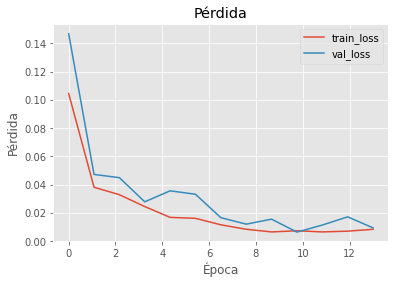

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.linspace(0, 13,13), M.history["loss"], label="train_loss")
plt.plot(np.linspace(0, 13,13), M.history["val_loss"], label="val_loss")
plt.title("Pérdida")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.ylim(0.)
plt.legend()

La pérdida de validación disminuye bruscamente en las dos primeras épocas y después se estabiliza en valores menores de 2 centésimas.

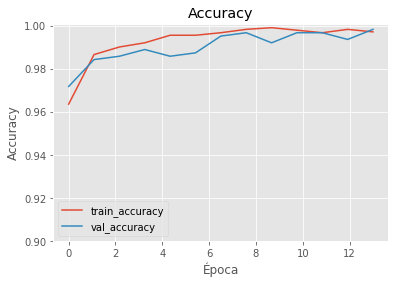

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.linspace(0, 13,13), M.history["accuracy"], label="train_accuracy")
plt.plot(np.linspace(0, 13,13), M.history["val_accuracy"], label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Época")
plt.ylim(0.9)
plt.ylabel("Accuracy")
plt.legend()

La precisión de validación se estabiliza en valores realmente cercanos al 1.

# Comprobación y resultados (sección 3.6 de la memoria)

## Conjunto de test de Varuna

Se testea el modelo con el conjunto de test (801 *croppies*):

In [ ]:
predictions = model.predict(x_test, batch_size=64)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       408
           1       1.00      1.00      1.00       393

    accuracy                           1.00       801
   macro avg       1.00      1.00      1.00       801
weighted avg       1.00      1.00      1.00       801



Los resultados son muy favorables. El algoritmo no falla en ninguna imagen. Se guardan las imágenes clasificadas por el algoritmo en dos directorios: **Mezcla_fuentes** y **Fuente_aislada_no_contaminada**

In [ ]:
predictions_list=predictions.tolist()
for  i in range(len(predictions_list)):
   nombre=nombres_test[i]
   if nombre in os.listdir("./drive/MyDrive/TFM/FINAL/Mezclado_SI_preprocesado_aumentado/"):
        if len(nombre)==25:
                nombre_original=nombre[2:]
        elif len(nombre)==26:
                nombre_original=nombre[3:]
        if (nombre_original not in os.listdir("./drive/MyDrive/TFM/FINAL/Mezcla_fuentes/")) and (nombre_original not in os.listdir("./drive/MyDrive/TFM/FINAL/Fuente_aislada_no_contaminada/")):
                imagen=cv2.imread("./drive/MyDrive/TFM/FINAL/Mezclado_SI/%s"%nombre_original)
                if (round(predictions_list[i][0])==0) and (round(predictions_list[i][1])==1):
                         imsave("./drive/MyDrive/TFM/FINAL/Mezcla_fuentes/%s"%nombre_original,imagen)
                else:
                         imsave("./drive/MyDrive/TFM/FINAL/Fuente_aislada_no_contaminada/%s"%nombre_original,imagen)

   else:
        imagen=cv2.imread("./drive/MyDrive/TFM/FINAL/Mezclado_NO/%s"%nombre)
        if (round(predictions_list[i][0])==0) and (round(predictions_list[i][1])==1):
                  imsave("./drive/MyDrive/TFM/FINAL/Mezcla_fuentes/%s"%nombre,imagen)
        else:
                  imsave("./drive/MyDrive/TFM/FINAL/Fuente_aislada_no_contaminada/%s"%nombre,imagen)

In [ ]:
print(len(os.listdir("./drive/MyDrive/TFM/FINAL/Fuente_aislada_no_contaminada/")))

408


## 2002_ms4

Para comprobar si el modelo es lo suficientemente válido es conveniente testear con *croppies* de otro asteroide: el 2002_ms4.

Al igual que en el caso de Varuna se cambian los nombres de los *croppies* por su fecha y se guardan las detecciones Positivas y Negativas:

In [ ]:
nombres_nuevos=[]
if os.path.isdir("./drive/MyDrive/TFM/2002_ms4/asteroid_found/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/2002_ms4/asteroid_found/"):
                imagen = cv2.imread("./drive/MyDrive/TFM/2002_ms4/asteroid_found/%s"%i)
                imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
                lista=[index for index, letra in enumerate(nombre) if letra=='T']
                if len(lista)==0:
                            imsave("./drive/MyDrive/TFM/FINAL/Positivas_2002_ms4/%s"%nombre,imagen)
                elif len(lista)==1:
                            index=lista[0]
                            año=nombre[index-10:index-6]
                            mes=nombre[index-5:index-3]
                            dia=nombre[index-2:index]
                            hora=nombre[index+1:index+3]
                            minuto=nombre[index+4:index+6]
                            segundo=nombre[index+7:index+9]
                            nombre_final=año+"-"+mes+"-"+dia+"_"+hora+":"+minuto+":"+segundo+".png"
                            if nombre_final in nombres_nuevos:
                                           imsave("./drive/MyDrive/TFM/FINAL/Positivas_2002_ms4/%s"%nombre,imagen)
                            else:
                                           imsave("./drive/MyDrive/TFM/FINAL/Positivas_2002_ms4/%s"%nombre_final,imagen)
                                           nombres_nuevos.append(nombre_final)

                elif len(lista)==2:
                           index=lista[1]
                           año=nombre[index-10:index-6]
                           mes=nombre[index-5:index-3]
                           dia=nombre[index-2:index]
                           hora=nombre[index+1:index+3]
                           minuto=nombre[index+4:index+6]
                           segundo=nombre[index+7:index+9]
                           nombre_final=año+"-"+mes+"-"+dia+"_"+hora+":"+minuto+":"+segundo+".png"
                           if nombre_final in nombres_nuevos:
                                            imsave("./drive/MyDrive/TFM/FINAL/Positivas_2002_ms4/%s"%nombre,imagen)
                           else:
                                            imsave("./drive/MyDrive/TFM/FINAL/Positivas_2002_ms4/%s"%nombre_final,imagen)
                                            nombres_nuevos.append(nombre_final)

                elif len(lista)>2:
                          index=lista[2]
                          año=nombre[index-10:index-6]
                          mes=nombre[index-5:index-3]
                          dia=nombre[index-2:index]
                          hora=nombre[index+1:index+3]
                          minuto=nombre[index+4:index+6]
                          segundo=nombre[index+7:index+9]
                          nombre_final=año+"-"+mes+"-"+dia+"_"+hora+":"+minuto+":"+segundo+".png"
                          if nombre_final in nombres_nuevos:
                                            imsave("./drive/MyDrive/TFM/FINAL/Positivas_2002_ms4/%s"%nombre,imagen)
                          else:
                                            imsave("./drive/MyDrive/TFM/FINAL/Positivas_2002_ms4/%s"%nombre_final,imagen)
                                            nombres_nuevos.append(nombre_final)

In [ ]:
nombres_nuevos=[]
if os.path.isdir("./drive/MyDrive/TFM/2002_ms4/asteroid_not_found/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/2002_ms4/asteroid_not_found/"):
                imagen = cv2.imread("./drive/MyDrive/TFM/2002_ms4/asteroid_not_found/%s"%i)
                imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
                lista=[index for index, letra in enumerate(nombre) if letra=='T']
                if len(lista)==0:
                            imsave("./drive/MyDrive/TFM/FINAL/Negativas_2002_ms4/%s"%nombre,imagen)
                elif len(lista)==1:
                            index=lista[0]
                            año=nombre[index-10:index-6]
                            mes=nombre[index-5:index-3]
                            dia=nombre[index-2:index]
                            hora=nombre[index+1:index+3]
                            minuto=nombre[index+4:index+6]
                            segundo=nombre[index+7:index+9]
                            nombre_final=año+"-"+mes+"-"+dia+"_"+hora+":"+minuto+":"+segundo+".png"
                            if nombre_final in nombres_nuevos:
                                           imsave("./drive/MyDrive/TFM/FINAL/Negativas_2002_ms4/%s"%nombre,imagen)
                            else:
                                           imsave("./drive/MyDrive/TFM/FINAL/Negativas_2002_ms4/%s"%nombre_final,imagen)
                                           nombres_nuevos.append(nombre_final)

                elif len(lista)==2:
                           index=lista[1]
                           año=nombre[index-10:index-6]
                           mes=nombre[index-5:index-3]
                           dia=nombre[index-2:index]
                           hora=nombre[index+1:index+3]
                           minuto=nombre[index+4:index+6]
                           segundo=nombre[index+7:index+9]
                           nombre_final=año+"-"+mes+"-"+dia+"_"+hora+":"+minuto+":"+segundo+".png"
                           if nombre_final in nombres_nuevos:
                                            imsave("./drive/MyDrive/TFM/FINAL/Negativas_2002_ms4/%s"%nombre,imagen)
                           else:
                                            imsave("./drive/MyDrive/TFM/FINAL/Negativas_2002_ms4/%s"%nombre_final,imagen)
                                            nombres_nuevos.append(nombre_final)

                elif len(lista)>2:
                          index=lista[2]
                          año=nombre[index-10:index-6]
                          mes=nombre[index-5:index-3]
                          dia=nombre[index-2:index]
                          hora=nombre[index+1:index+3]
                          minuto=nombre[index+4:index+6]
                          segundo=nombre[index+7:index+9]
                          nombre_final=año+"-"+mes+"-"+dia+"_"+hora+":"+minuto+":"+segundo+".png"
                          if nombre_final in nombres_nuevos:
                                            imsave("./drive/MyDrive/TFM/FINAL/Negativas_2002_ms4/%s"%nombre,imagen)
                          else:
                                            imsave("./drive/MyDrive/TFM/FINAL/Negativas_2002_ms4/%s"%nombre_final,imagen)
                                            nombres_nuevos.append(nombre_final)

### Código de descarte

Se vuelve a aplicar el código para descartar todos los *croppies* de mala calidad y contaminados antes de clasificar. Es el mismo que para Varuna. 

In [ ]:
if os.path.isdir("./drive/MyDrive/TFM/FINAL/Negativas_2002_ms4/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/FINAL/Negativas_2002_ms4/"):
                imagen_original= cv2.imread("./drive/MyDrive/TFM/FINAL/Negativas_2002_ms4/%s"%nombre)
                imagen_color=cv2.cvtColor(imagen_original, cv2.COLOR_BGR2RGB)
                imagen_gris = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)
                imagen=preprocesado(imagen_original)
                imagen=img_as_ubyte(imagen)
                num_pixeles_asteroide=np.sum(imagen == 255)
                if num_pixeles_asteroide==0:
                    imsave("./drive/MyDrive/TFM/FINAL/DESCARTADAS_NEGATIVAS_2002_ms4/%s"%nombre,imagen_color)
                 
                else:
                    ret,imagen2=cv2.threshold(imagen_gris, 0, 255, cv2.THRESH_BINARY)
                    imagen2=img_as_ubyte(imagen2)
                    num_pixeles_fuentes=np.sum(imagen2 == 255)
                    num_pixeles_sin_fuentes=np.sum(imagen2== 0)
                    porcent= num_pixeles_fuentes/(num_pixeles_sin_fuentes+num_pixeles_fuentes)
                    cuadro=recorte(imagen_color)
                    color_mayoritario_cuadro, frecuencia_maxima_cuadro, colores_cuadro,frecuencias_cuadro=colores(cuadro)
                    if porcent>=0.3:
                        imsave("./drive/MyDrive/TFM/FINAL/DESCARTADAS_NEGATIVAS_2002_ms4/%s"%nombre,imagen_color)
                    elif no_contaminada(imagen_color,4)==False:
                        imsave("./drive/MyDrive/TFM/FINAL/DESCARTADAS_NEGATIVAS_2002_ms4/%s"%nombre,imagen_color)
                    elif pixeles_continuos_horizontales(cuadro,3)==False or pixeles_continuos_verticales(cuadro,3)==False or (frecuencia_maxima_cuadro<=7) or len(colores_cuadro)>1:
                        imsave("./drive/MyDrive/TFM/FINAL/DESCARTADAS_NEGATIVAS_2002_ms4/%s"%nombre,imagen_color)
                    else:
                        imsave("./drive/MyDrive/TFM/FINAL/FILTRADAS_NEGATIVAS_2002_ms4/%s"%nombre,imagen_color)

In [ ]:
print(len(os.listdir("./drive/MyDrive/TFM/FINAL/DESCARTADAS_NEGATIVAS_2002_ms4/")))

741


In [ ]:
print(len(os.listdir("./drive/MyDrive/TFM/FINAL/FILTRADAS_NEGATIVAS_2002_ms4/")))

4


In [ ]:
if os.path.isdir("./drive/MyDrive/TFM/FINAL/Positivas_2002_ms4/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/FINAL/Positivas_2002_ms4/"):
                imagen_original= cv2.imread("./drive/MyDrive/TFM/FINAL/Positivas_2002_ms4/%s"%nombre)
                imagen_color=cv2.cvtColor(imagen_original, cv2.COLOR_BGR2RGB)
                imagen_gris = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)
                imagen=preprocesado(imagen_original)
                imagen=img_as_ubyte(imagen)
                num_pixeles_asteroide=np.sum(imagen == 255)
                if num_pixeles_asteroide==0:
                    imsave("./drive/MyDrive/TFM/FINAL/DESCARTADAS_POSITIVAS_2002_ms4/%s"%nombre,imagen_color)
                 
                else:
                    ret,imagen2=cv2.threshold(imagen_gris, 0, 255, cv2.THRESH_BINARY)
                    imagen2=img_as_ubyte(imagen2)
                    num_pixeles_fuentes=np.sum(imagen2 == 255)
                    num_pixeles_sin_fuentes=np.sum(imagen2== 0)
                    porcent= num_pixeles_fuentes/(num_pixeles_sin_fuentes+num_pixeles_fuentes)
                    cuadro=recorte(imagen_color)
                    color_mayoritario_cuadro, frecuencia_maxima_cuadro, colores_cuadro,frecuencias_cuadro=colores(cuadro)
                    if porcent>=0.3:
                        imsave("./drive/MyDrive/TFM/FINAL/DESCARTADAS_POSITIVAS_2002_ms4/%s"%nombre,imagen_color)
                    elif no_contaminada(imagen_color,4)==False:
                        imsave("./drive/MyDrive/TFM/FINAL/DESCARTADAS_POSITIVAS_2002_ms4/%s"%nombre,imagen_color)
                    elif pixeles_continuos_horizontales(cuadro,3)==False or pixeles_continuos_verticales(cuadro,3)==False or (frecuencia_maxima_cuadro<=7) or len(colores_cuadro)>1:
                        imsave("./drive/MyDrive/TFM/FINAL/DESCARTADAS_POSITIVAS_2002_ms4/%s"%nombre,imagen_color)
                    else:
                        imsave("./drive/MyDrive/TFM/FINAL/FILTRADAS_POSITIVAS_2002_ms4/%s"%nombre,imagen_color)

In [ ]:
print(len(os.listdir("./drive/MyDrive/TFM/FINAL/DESCARTADAS_POSITIVAS_2002_ms4/")))

248


In [ ]:
print(len(os.listdir("./drive/MyDrive/TFM/FINAL/FILTRADAS_POSITIVAS_2002_ms4/")))

305


Creamos el conjunto de test con los *croppies* que han pasado el control de calidad. Deben someterse al mismo preprocesamiento que los de entrenamiento de la red, como es lógico.

In [ ]:
if os.path.isdir("./drive/MyDrive/TFM/FINAL/FILTRADAS_POSITIVAS_2002_ms4/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/FINAL/FILTRADAS_POSITIVAS_2002_ms4/"):
             if nombre.endswith(".png"):
              imagen = cv2.imread("./drive/MyDrive/TFM/FINAL/FILTRADAS_POSITIVAS_2002_ms4/%s"%nombre)
              imagen=preprocesado(imagen)
              imagen = img_as_float(imagen)
              imsave("./drive/MyDrive/TFM/FINAL/FILTRADAS_POSITIVAS_PREPROCESADAS_2002_ms4/%s"%nombre,imagen)
              

if os.path.isdir("./drive/MyDrive/TFM/FINAL/FILTRADAS_NEGATIVAS_2002_ms4/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/FINAL/FILTRADAS_NEGATIVAS_2002_ms4/"):
             if nombre.endswith(".png"):
              imagen = cv2.imread("./drive/MyDrive/TFM/FINAL/FILTRADAS_NEGATIVAS_2002_ms4/%s"%nombre)
              imagen=preprocesado(imagen)
              imagen = img_as_float(imagen)
              imsave("./drive/MyDrive/TFM/FINAL/FILTRADAS_NEGATIVAS_PREPROCESADAS_2002_ms4/%s"%nombre,imagen)

In [ ]:
x_test_ms4=np.zeros((309,40,50))
x_test_ms4_color=[]
nombres_test_ms4=[]
n=0
if os.path.isdir("./drive/MyDrive/TFM/FINAL/FILTRADAS_POSITIVAS_PREPROCESADAS_2002_ms4/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/FINAL/FILTRADAS_POSITIVAS_PREPROCESADAS_2002_ms4/"):
                nombres_test_ms4.append(nombre)
                imagen = cv2.imread("./drive/MyDrive/TFM/FINAL/FILTRADAS_POSITIVAS_PREPROCESADAS_2002_ms4/%s"%nombre)
                imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
                x_test_ms4[n]=imagen
                imagen_color = cv2.imread("./drive/MyDrive/TFM/FINAL/FILTRADAS_POSITIVAS_2002_ms4/%s"%nombre)
                imagen_color = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB)
                x_test_ms4_color.append(imagen_color)
                n+=1
if os.path.isdir("./drive/MyDrive/TFM/FINAL/FILTRADAS_NEGATIVAS_PREPROCESADAS_2002_ms4/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/FINAL/FILTRADAS_NEGATIVAS_PREPROCESADAS_2002_ms4/"):
                nombres_test_ms4.append(nombre)
                imagen = cv2.imread("./drive/MyDrive/TFM/FINAL/FILTRADAS_NEGATIVAS_PREPROCESADAS_2002_ms4/%s"%nombre)
                imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
                x_test_ms4[n]=imagen
                imagen_color = cv2.imread("./drive/MyDrive/TFM/FINAL/FILTRADAS_NEGATIVAS_2002_ms4/%s"%nombre)
                imagen_color = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB)
                x_test_ms4_color.append(imagen_color)
                n+=1

In [ ]:
x_test_ms4_expand=np.expand_dims(x_test_ms4,3)

Guardamos los *croppies* clasificados por el algoritmo en dos carpetas: **Mezcla_fuentes_2002_ms4** y **Fuente_aislada_no_contaminada_2002_ms4**

In [ ]:
predictions = model.predict(x_test_ms4_expand, batch_size=64)

In [ ]:
predictions_list=predictions.tolist()
for  i in range(len(predictions_list)):
   nombre=nombres_test_ms4[i]
   imagen=x_test_ms4_color[i]
   if (round(predictions_list[i][0])==0) and (round(predictions_list[i][1])==1):
      imsave("./drive/MyDrive/TFM/FINAL/Mezcla_fuentes_2002_ms4/%s"%nombre,imagen)
      
   else:
      imsave("./drive/MyDrive/TFM/FINAL/Fuente_aislada_no_contaminada_2002_ms4/%s"%nombre,imagen)

In [ ]:
print(len(os.listdir("./drive/MyDrive/TFM/FINAL/Fuente_aislada_no_contaminada_2002_ms4/")))

298


Examinando los *croppies* resultantes se puede ver que contienen **5 falsos positivos**, todos de la misma fecha (2010-06-06). Es decir el algoritmo ha clasificado 5 fuentes mezcladas como si se tratasen de fuentes aisladas. Todos los demás se tratan realmente de fuentes aisladas.

Además el algoritmo ha descartado 11 *croppies* como si se tratasen de fuentes mezcladas, cuando en realidad se tratan de fuentes aisladas: **11 falsos negativos**. 8 de ellos pertenecen a la misma fecha (2017-06-30) y se tratan de los casos problemáticos para el algoritmo: confunde mezclas muy solapadas con fuentes aisladas de forma regular. De hecho, los demás *croppies* de esa misma fecha los clasifica correctamente.

Dichos *croppies* se guardan en la carpeta **Mal_clasificadas_2002_ms4**

### Conjunto ampliado de test

Se añaden las 70 mezclas contaminadas al conjunto de test para poder obtener todas las métricas:

In [ ]:
print(len(os.listdir('./drive/MyDrive/TFM/FINAL/Mezclado_SI_2002_ms4')))

70


In [ ]:
imagenes=[]
y=[]
for i in range(0,20):
  nombre=os.listdir("./drive/MyDrive/TFM/FINAL/Mezclado_SI_2002_ms4/")[i]
  imagen=cv2.imread("./drive/MyDrive/TFM/FINAL/Mezclado_SI_2002_ms4/%s"%nombre)
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
  imagenes.append(imagen)
  y.append('Mezcla_fuentes')

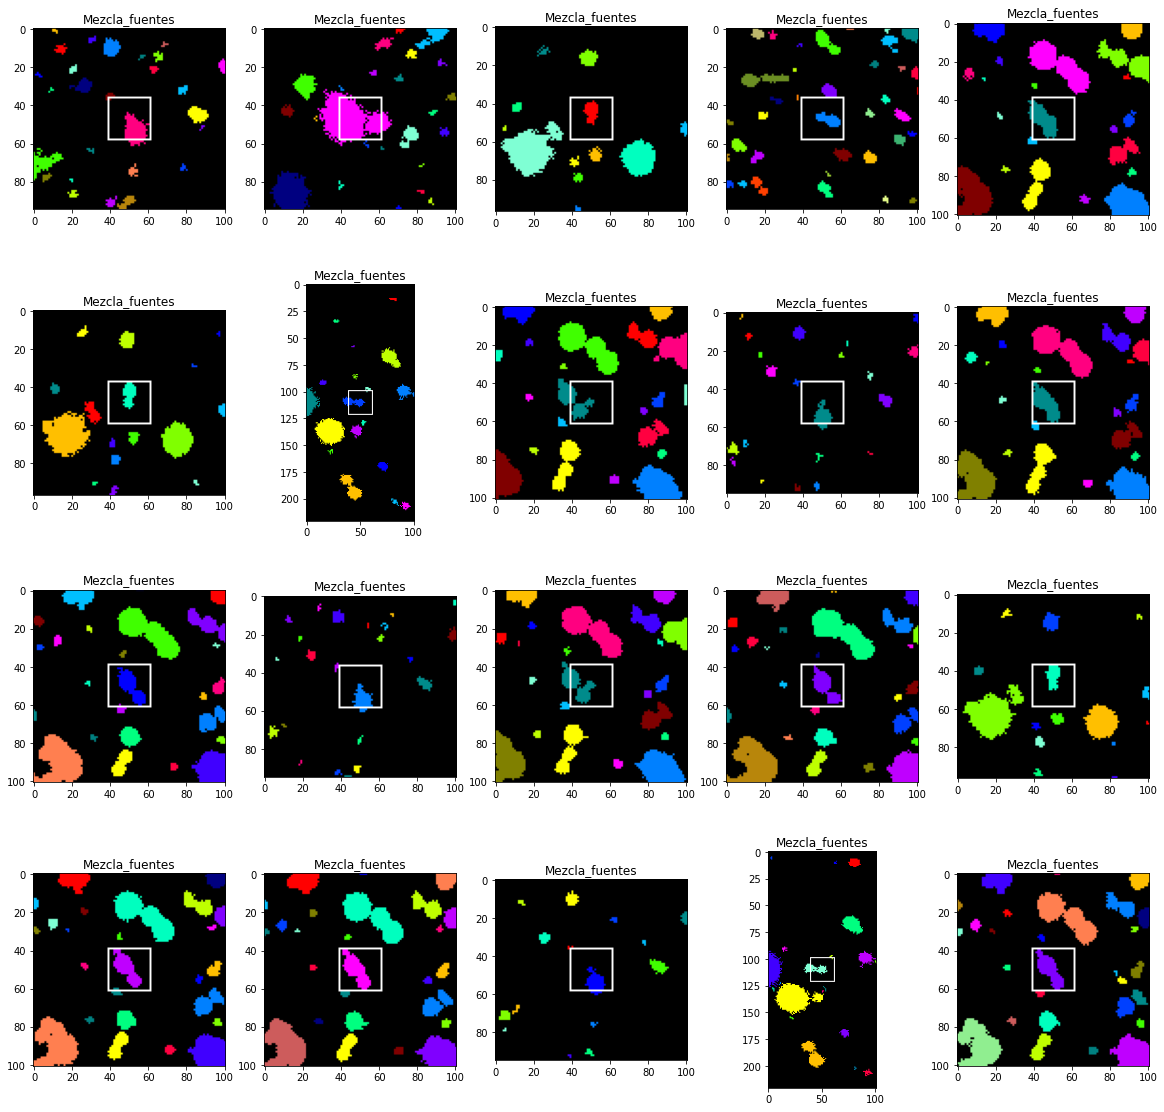

In [ ]:
fig,axs=plt.subplots(4,5,figsize=(20, 20))

for ax,imagen,etiqueta in zip(axs.flatten(),imagenes,y):
  ax.imshow(imagen)
  ax.set_title(etiqueta)

Se preprocesan:

In [ ]:
if os.path.isdir("./drive/MyDrive/TFM/FINAL/Mezclado_SI_2002_ms4/"):
              imagen = cv2.imread("./drive/MyDrive/TFM/FINAL/2002_ms4/Mezclado_SI_2002_ms4/%s"%nombre)
              imagen=preprocesado(imagen)
              imagen = img_as_float(imagen)
              imsave("./drive/MyDrive/TFM/FINAL/Mezclado_SI_preprocesado_2002_ms4/%s"%nombre,imagen)

In [ ]:
imagenes_prep=[]
y=[]
for i in range(0,20):
  nombre=os.listdir("./drive/MyDrive/TFM/FINAL/Mezclado_SI_preprocesado_2002_ms4/")[i]
  imagen=cv2.imread("./drive/MyDrive/TFM/FINAL/Mezclado_SI_preprocesado_2002_ms4/%s"%nombre)
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
  imagenes_prep.append(imagen)
  y.append('Mezcla_fuentes')

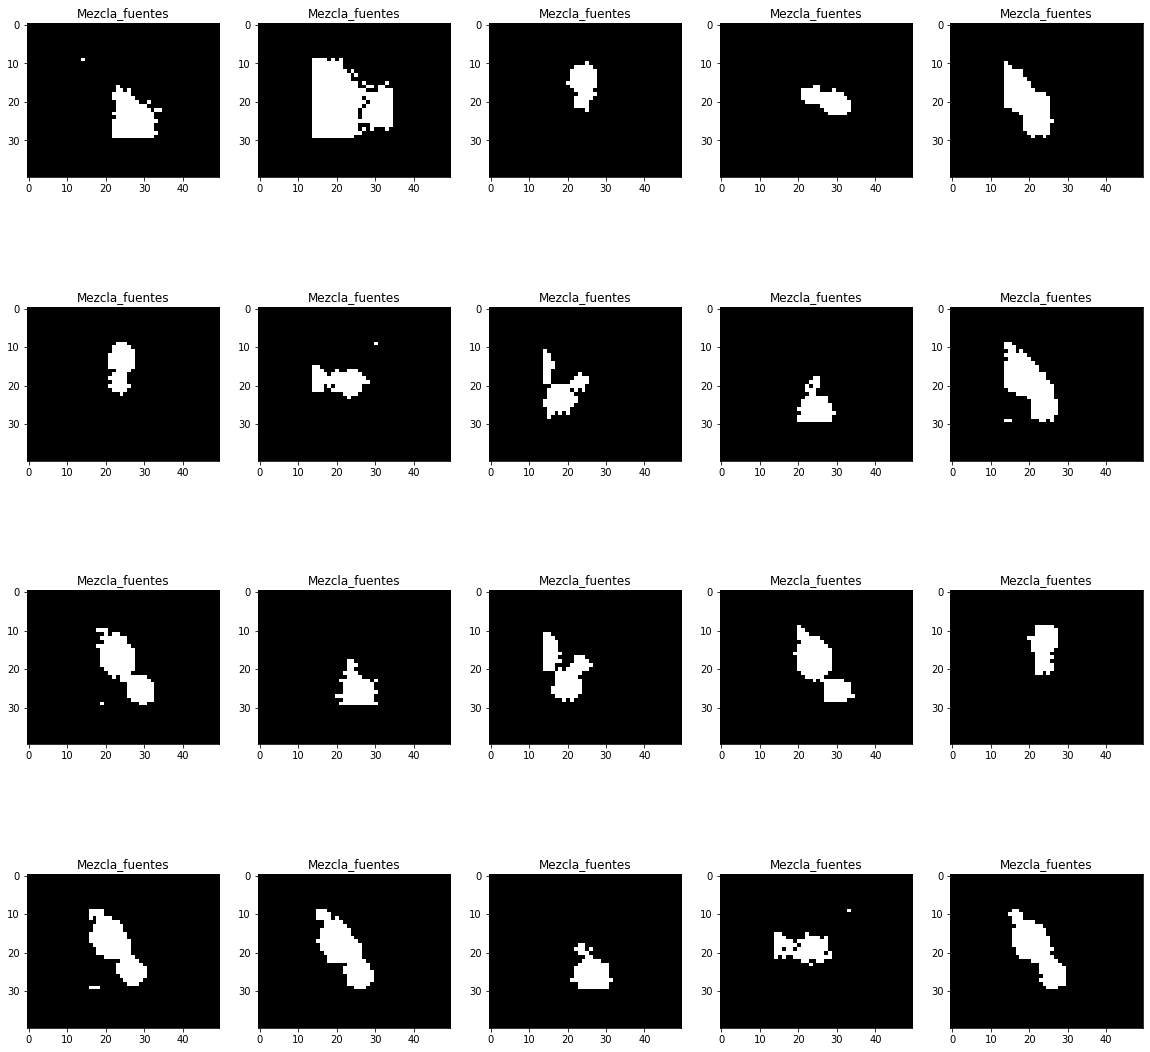

In [ ]:
fig,axs=plt.subplots(4,5,figsize=(20, 20))

for ax,imagen,etiqueta in zip(axs.flatten(),imagenes_prep,y):
  ax.imshow(imagen)
  ax.set_title(etiqueta)

Conjunto de test ampliado:

In [ ]:
x_test_ms4=np.zeros((379,40,50))
x_test_ms4_color=[]
nombres_test_ms4=[]
n=0
if os.path.isdir("./drive/MyDrive/TFM/FINAL/FILTRADAS_POSITIVAS_PREPROCESADAS_2002_ms4/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/FINAL/FILTRADAS_POSITIVAS_PREPROCESADAS_2002_ms4/"):
                nombres_test_ms4.append(nombre)
                imagen = cv2.imread("./drive/MyDrive/TFM/FINAL/FILTRADAS_POSITIVAS_PREPROCESADAS_2002_ms4/%s"%nombre)
                imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
                x_test_ms4[n]=imagen
                imagen_color = cv2.imread("./drive/MyDrive/TFM/FINAL/FILTRADAS_POSITIVAS_2002_ms4/%s"%nombre)
                imagen_color = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB)
                x_test_ms4_color.append(imagen_color)
                n+=1
if os.path.isdir("./drive/MyDrive/TFM/FINAL/FILTRADAS_NEGATIVAS_PREPROCESADAS_2002_ms4/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/FINAL/FILTRADAS_NEGATIVAS_PREPROCESADAS_2002_ms4/"):
                nombres_test_ms4.append(nombre)
                imagen = cv2.imread("./drive/MyDrive/TFM/FINAL/FILTRADAS_NEGATIVAS_PREPROCESADAS_2002_ms4/%s"%nombre)
                imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
                x_test_ms4[n]=imagen
                imagen_color = cv2.imread("./drive/MyDrive/TFM/FINAL/FILTRADAS_NEGATIVAS_2002_ms4/%s"%nombre)
                imagen_color = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB)
                x_test_ms4_color.append(imagen_color)
                n+=1
if os.path.isdir("./drive/MyDrive/TFM/FINAL/Mezclado_SI_preprocesado_2002_ms4/"):
         for nombre in os.listdir("./drive/MyDrive/TFM/FINAL/Mezclado_SI_preprocesado_2002_ms4/"):
                nombres_test_ms4.append(nombre)
                imagen = cv2.imread("./drive/MyDrive/TFM/FINAL/Mezclado_SI_preprocesado_2002_ms4/%s"%nombre)
                imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
                x_test_ms4[n]=imagen
                imagen_color = cv2.imread("./drive/MyDrive/TFM/FINAL/Mezclado_SI_2002_ms4/%s"%nombre)
                imagen_color = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB)
                x_test_ms4_color.append(imagen_color)
                n+=1

In [ ]:
x_test_ms4_expand=np.expand_dims(x_test_ms4,3)

In [ ]:
predictions = model.predict(x_test_ms4_expand, batch_size=64)

In [ ]:
predictions_list=predictions.tolist()
for  i in range(len(predictions_list)):
   print(i)
   nombre=nombres_test_ms4[i]
   imagen=x_test_ms4_color[i]
   if (round(predictions_list[i][0])==0) and (round(predictions_list[i][1])==1):
      imsave("./drive/MyDrive/TFM/FINAL/Mezcla_fuentes_2002_ms4_2/%s"%nombre,imagen)
      
   else:
      imsave("./drive/MyDrive/TFM/FINAL/Fuente_aislada_no_contaminada_2002_ms4_2/%s"%nombre,imagen)

In [ ]:
print(len(os.listdir("./drive/MyDrive/TFM/FINAL/Fuente_aislada_no_contaminada_2002_ms4_2/")))

306


In [ ]:
print(len(os.listdir("./drive/MyDrive/TFM/FINAL/Mezcla_fuentes_2002_ms4_2/")))

73
